In [2]:
import math
import os
import shutil
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
from os import walk, getcwd

from sklearn.model_selection import train_test_split
#from tqdm import tqdm

In [11]:
#Creation of the classes one desires to train YOLO with
wnid_list =["n02876657" , "n02747177"] #bottle , trash
classes = ["bottle", "bins"] #n02876657, n02747177
batch_nb =8

In [12]:
wd = getcwd()
if not os.path.exists(os.path.join(wd + '/XmlToTxt')):
    !git clone https://github.com/Isabek/XmlToTxt
#!cd XmlToTxt && pip install -r requirements.txt

In [13]:
import time
import tarfile

if sys.version_info >= (3,):
    import urllib.request as urllib2
    import urllib.parse as urlparse
else:
    import urllib2
    import urlparse
    import urllib

class ImageNetDownloader:
    def __init__(self):
        self.host = 'http://www.image-net.org'

    def download_file(self, url, desc=None, renamed_file=None):
        print(url)

        u = urllib2.urlopen(url)

        scheme, netloc, path, query, fragment = urlparse.urlsplit(url)
        filename = os.path.basename(path)
        if not filename:
            filename = 'downloaded.file'

        if not renamed_file is None:
            filename = renamed_file

        if desc:
            filename = os.path.join(desc, filename)

        with open(filename, 'wb') as f:
            meta = u.info()
            meta_func = meta.getheaders if hasattr(meta, 'getheaders') else meta.get_all
            meta_length = meta_func("Content-Length")
            file_size = None
            if meta_length:
                file_size = int(meta_length[0])
            print("Downloading: {0} Bytes: {1}".format(url, file_size))

            file_size_dl = 0
            block_sz = 8192
            while True:
                buffer = u.read(block_sz)
                if not buffer:
                    break

                file_size_dl += len(buffer)
                f.write(buffer)

                status = "{0:16}".format(file_size_dl)
                if file_size:
                    status += "   [{0:6.2f}%]".format(file_size_dl * 100 / file_size)
                status += chr(13)

        return filename

    def extractTarfile(self, filename):
        tar = tarfile.open(filename)
        tar.extractall()
        tar.close()

    def downloadBBox(self, wnid):
        filename = str(wnid) + '.tar.gz'
        url = self.host + '/downloads/bbox/bbox/' + filename
        try:
            filename = self.download_file(url, self.mkWnidDir(wnid))

            currentDir = os.getcwd()
            os.chdir(wnid)
            self.extractTarfile(filename)
            print ('Download bbbox annotation from ' + url + ' to ' + filename)
            os.chdir(currentDir)
        except (Exception):
            print ('Fail to download')

    def getImageURLsOfWnid(self, wnid):
        url = 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=' + str(wnid)
        f = urllib2.urlopen(url)
        contents = f.read().decode('utf-8').split('\n')
        imageUrls = []

        for each_line in contents:
            # Remove unnecessary char
            each_line = each_line.replace('\r', '').strip()
            if each_line:
                imageUrls.append(each_line)

        return imageUrls

    def mkWnidDir(self, wnid):
        if not os.path.exists(wnid):
            os.mkdir(wnid)
        return os.path.abspath(wnid)

    def downloadImagesByURLs(self, wnid, imageUrls):
        # save to the dir e.g: n005555_urlimages/
        limit = 20
        count = 0
        wnid_urlimages_dir = os.path.join(self.mkWnidDir(wnid), str(wnid) + '_urlimages')
        if not os.path.exists(wnid_urlimages_dir):
            os.mkdir(wnid_urlimages_dir)

        for url in imageUrls:
            if count < limit :
                try:
                    self.download_file(url, wnid_urlimages_dir)
                    #count +=1
                except (Exception):
                    print ("Fail to download")

    def downloadOriginalImages(self, wnid, username, accesskey):
            download_url = 'http://www.image-net.org/download/synset?wnid=%s&username=%s&accesskey=%s&release=latest&src=stanford' % (wnid, username, accesskey)
            try:
                 download_file = self.download_file(download_url, self.mkWnidDir(wnid), wnid + '_original_images.tar')
            except Exception:
                print ('Fail to download : ' , download_url)

            currentDir = os.getcwd()
            extracted_folder = os.path.join(wnid, wnid + '_original_images')
            if not os.path.exists(extracted_folder):
                os.mkdir(extracted_folder)
            os.chdir(extracted_folder)
            self.extractTarfile(download_file)
            os.chdir(currentDir)
            print ('Extract images to ' , extracted_folder)


In [107]:
downloader = ImageNetDownloader()


for id in wnid_list:

    # Download annotation files
    if not os.path.exists(os.path.join(wd, id)):
        downloader.downloadBBox(id)
        downloader.downloadOriginalImages(id, "bledem", "99673036c477ac827939b6566e2026b3a2d04764")
    else:
        print(os.path.join(wd, id), "already exists")

    

/home/ubuntu/project_kaggle/YOLO3/n02876657 already exists
/home/ubuntu/project_kaggle/YOLO3/n02747177 already exists


In [5]:
from PIL import Image


def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)



Conerting in YOLO format and save the txt file in the original_image folder

In [14]:
!export mypath && export outpath

#write the classes id in for the conversion in classes.txt
classes_file = open('%s/XmlToTxt/classes.txt'%(wd), 'w+')
for cls in wnid_list :
    classes_file.write(cls+"\n")
classes_file.close()
names_all=[]

#For each classe we run the conversion python script
for id,cls in enumerate(classes) :
    mypath = wd + "/"+ wnid_list[id]+"/Annotation/"+wnid_list[id]
    #print("input path", mypath)
    outpath = wd + "/"+ wnid_list[id]+"/"+wnid_list[id]+"_original_images"
    #print("output path", outpath)
    os.environ['mypath'] = mypath
    os.environ['outpath'] = outpath

    #list_file = open('%s/%s%s_list.txt'%(wd, cls, wnid_list[id]), 'w+')
    cls_id = classes.index(cls)
    

    !cd XmlToTxt && python xmltotxt.py -xml $mypath -out $outpath
    
    """ Get input text file list """
    txt_name_list = []
    img_path_list = []


    for (dirpath, dirnames, filenames) in walk(outpath):
        txt_name_list.extend(filenames)
        file_name_list_nan = ["n"+ elt[1:(len(elt)-4)] for elt in filenames if "txt" in elt]
        txt_path_list= [outpath+ "/n" + elt for elt in filenames if "txt" in elt]
        break

    names_all.append(file_name_list_nan)

#As a result we have a list of list of id_name for the boxes

    print(cls, "is one id class on ",len(names_all), " classes.", "Sample names", names_all[id][0], ". This cls contains ",
         len(names_all[id]), " label file.")

   
    

bottle is one id class on  1  classes. Sample names n02876657_981 . This cls contains  213  label file.
bins is one id class on  2  classes. Sample names n02747177_17569 . This cls contains  457  label file.


Plot a sample train imag and label

In [18]:
import random

names_matched_all=[]
no_img_count=[0,0];
#check if the image exists for each label file
for id in range(len(names_all)):
    file_name_list=[]
    for elt in names_all[id]:
        ex_bottle_img_path = os.path.join(wd, "{}/{}_original_images/{}.JPEG".format(wnid_list[id],wnid_list[id],elt))
        if os.path.exists(ex_bottle_img_path): 
            file_name_list.append(elt)
        else :
            no_img_count[id]+=1
            #print("bbox but no image", ex_bottle_img_path)
    names_matched_all.append(file_name_list)
    print(len(names_matched_all[id]), "with ", no_img_count[id], "labels with no img" )





213 with  0 labels with no img
313 with  144 labels with no img


Prompt one example of training image

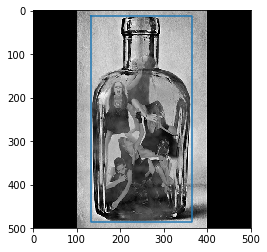

In [19]:
index = random.randrange( len(names_matched_all[0]) )

ex_bottle_id = names_matched_all[0][index]

ex_bottle_img_path = os.path.join(wd, "{}/{}_original_images/{}.JPEG".format(wnid_list[0],wnid_list[0],ex_bottle_id))
ex_bins_label_path = os.path.join(wd, "{}/{}_original_images/{}.txt".format(wnid_list[0],wnid_list[0],ex_bottle_id))

#print(ex_bottle_img_path)
plt.imshow(cv2.imread(ex_bottle_img_path))
height, width, channels = cv2.imread(ex_bottle_img_path).shape
with open(ex_bins_label_path, "r") as f:
    for line in f:
        #print(line)
        class_id, rcx, rcy, rw, rh = map(float, line.strip().split())
        x = (rcx-rw/2)*width
        y = (rcy-rh/2)*height
        w = rw*width
        h = rh*height
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

In [20]:
if not os.path.exists(os.path.join(wd + '/darknet')):

    !git clone https://github.com/pjreddie/darknet.git

    # Build gpu version darknet
    !cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

    # -j <The # of cpu cores to use>. Chang 999 to fit your environment. Actually i used '-j 50'.
    !cd darknet && make -j 4 -s
    !cp darknet/darknet darknet_gpu

In [21]:
def write_train_list(metadata_dir, img_dir, name, series, first):
    list_fp = os.path.join(metadata_dir, name)
    if first==0:
        f=  open(list_fp, "w+") 
    else:
        f=  open(list_fp, "a") 
    for patient_id in series:
        line = "{}\n".format(os.path.join(img_dir, "{}.JPEG".format(patient_id)))
        f.write(line)

Create a training, test and validation set

In [23]:
random_stat = 123
np.random.seed(random_stat)

for id, cls in enumerate(names_matched_all):
    tr_series, val_series = train_test_split(names_matched_all[id], test_size=0.1, random_state=random_stat)
    print("For the class", classes[id],", the # of train set: {}, The # of validation set: {}".format(len(tr_series), len(val_series)))

    #define the directories
    metadata_dir = os.path.join(wd, "metadata") # .txt
    img_dir =  os.path.join(wd, "{}/{}_original_images".format(wnid_list[id],wnid_list[id]))
    label_dir = os.path.join(wd, "{}/{}_original_images/{}.txt".format(wnid_list[id],wnid_list[id], ex_bottle_id))


    # train image path list
    write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series, id)
    # validation image path list
    write_train_list(metadata_dir, img_dir, "val_list.txt", val_series, id)
    test_name_list = names_matched_all[id].copy()
    random.shuffle(test_name_list)
    write_train_list(metadata_dir, img_dir, "te_list.txt", test_name_list[:20],id)


For the class bottle , the # of train set: 191, The # of validation set: 22
For the class bins , the # of train set: 281, The # of validation set: 32


# Print a test example

/home/ubuntu/project_kaggle/YOLO3/n02747177/n02747177_original_images/n02747177_14520.JPEG n02747177_14520


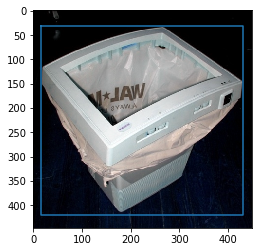

In [32]:
index = random.randrange( len(test_name_list) )

ex_patient_id = test_name_list[index]
ex_img_path = os.path.join(wd, "{}/{}_original_images/{}.JPEG".format(wnid_list[1],wnid_list[1],ex_patient_id))
print(ex_img_path, ex_patient_id)
plt.imshow(cv2.imread(ex_img_path))
height, width, channels = cv2.imread(ex_img_path).shape

with open(os.path.join(wd, "{}/{}_original_images/{}.txt".format(wnid_list[1],wnid_list[1],ex_patient_id)), "r") as f:
    for line in f:
        #print(line)
        class_id, rcx, rcy, rw, rh = map(float, line.strip().split())
        x = (rcx-rw/2)*width
        y = (rcy-rh/2)*height
        w = rw*width
        h = rh*height
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

## 3. Prepare Configuration Files for Using YOLOv3


In [35]:
# YOLOv3 config file directory
cfg_dir = os.path.join(os.getcwd(), "cfg")
# YOLOv3 training checkpoints will be saved here
backup_dir = os.path.join(os.getcwd(), "backup")

data_extention_file_path = os.path.join(cfg_dir, 'yolo_imagenet.data')
with open(data_extention_file_path, 'w') as f:  
    contents = """classes= {}
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(len(classes),
               os.path.join(metadata_dir, "tr_list.txt"),
               os.path.join(metadata_dir, "val_list.txt"),
               os.path.join(cfg_dir, 'yolo_imagenet.names'),
               backup_dir)
    f.write(contents)
with open(os.path.join(cfg_dir, 'yolo_imagenet.names'), 'w') as f:  
    for cls in classes:
        f.write(cls+"\n")
        

In [36]:
!cat cfg/yolo_imagenet.data

classes= 2
train  = /home/ubuntu/project_kaggle/YOLO3/metadata/tr_list.txt
valid  = /home/ubuntu/project_kaggle/YOLO3/metadata/val_list.txt
names  = /home/ubuntu/project_kaggle/YOLO3/cfg/yolo_imagenet.names
backup = /home/ubuntu/project_kaggle/YOLO3/backup
    

In [152]:
if not os.path.exists(os.path.join(wd + '/darknet53.conv.74')):
    !wget -q https://pjreddie.com/media/files/darknet53.conv.74

In [153]:
#TO DO modify the number of input classes

mypath = wd + "/darknet/cfg/yolov3.cfg"
outpath = wd + "/cfg/yolov3_{}.cfg_train".format(len(classes))

training_batch=0
yolo_cfg_file = open(mypath, "r")
new_cfg_file = open(outpath, "w+")
for line in yolo_cfg_file :    
    if "classes" in line:
        new_cfg_file.write("classes={}\n".format(len(classes)))
    elif "Training" in line :
        training_batch = True
        new_cfg_file.write(line)

    elif training_batch:
        new_cfg_file.write("batch={}\n".format(batch_nb))
        training_batch = False
    else:
        new_cfg_file.write(line)
os.environ['outpath'] = outpath

#TO CREATE backup


In [ ]:
!./darknet_gpu detector train cfg/yolo_imagenet.data cfg/yolo_imagenet.cfg_train darknet53.conv.74 -i 0 | tee train_log.txt
#!./darknet_gpu detector train cfg/yolo_imagenet.data cfg/yolov3_2.cfg_train darknet53.conv.74 -i 0 | tee train_log.txt